# Popular Names in South Australia

This project explores popular baby names from 1944-2013 in South Australia. The dataset is taken from https://data.sa.gov.au/data/dataset/popular-baby-names

### Load in the data
There are multiple files, two per year - one for female names and one for male names.<br>
We combine all the files into one dataframe.
We also add new `gender` and `year` columns.

In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

file_list = glob.glob('./data/*.csv') 
df = pd.DataFrame()

for f in file_list:
    df_tmp = pd.read_csv(f)
    i = f.find('cy')
    df_tmp['year'] = f[i+2:i+6]
    i = f.find('\\')
    df_tmp['sex'] = f[i+1]
    df = pd.concat([df, df_tmp],ignore_index=True)

In [2]:
df.head()

,Given Name,Amount,Position,year,sex
0,MARGARET,341,1,1944,f
1,HELEN,209,2,1944,f
2,JUDITH,189,3,1944,f
3,PATRICIA,186,4,1944,f
4,PAMELA,160,5,1944,f


The `position` column is not needed so we drop it.

In [3]:
df.drop('Position', axis=1, inplace=True)

In [4]:
df.head()

,Given Name,Amount,year,sex
0,MARGARET,341,1944,f
1,HELEN,209,1944,f
2,JUDITH,189,1944,f
3,PATRICIA,186,1944,f
4,PAMELA,160,1944,f


### Clean the data
First we identify and drop rows whic have null values in the `Given Name` column

In [5]:
df['Given Name'].isnull().sum()

1

In [6]:
df[df['Given Name'].isnull()]

,Given Name,Amount,year,sex
58731,NaN,1,1985,f


In [7]:
df.loc[58730:58732]

,Given Name,Amount,year,sex
58730,MYRA,1,1985,f
58731,NaN,1,1985,f
58732,NAARAH,1,1985,f


In [8]:
df.dropna(subset=['Given Name'],inplace=True)
df['Given Name'].isnull().sum()

0

Next we identify duplicated rows on `Given Name` and `year` and sum the amount, results stored in a series.

In [9]:
dups = df[df.duplicated(['Given Name','year','sex'],keep=False)].groupby(['Given Name','year','sex']).Amount.sum()

Convert the series into a new dataframe.

In [10]:
df_dup = dups.to_frame()

In [11]:
df_dup.head()

Amount
Given Name year sex        
(NOT       1968 m         4
AARON      1963 m         8
           1968 m        21
           1969 m        10
           1970 m        31

In [12]:
df.shape[0]

210938

In [13]:
df.duplicated(['Given Name','year','sex'],keep=False).value_counts()

False    206883
True       4055
dtype: int64

We drop duplicates in our original dataframe, keeping only one occurrence.

In [14]:
#drop duplicates keep first occurrence only
df.drop_duplicates(['Given Name','year','sex'],inplace=True) 

In [15]:
df.duplicated(['Given Name','year','sex'],keep=False).value_counts()

False    208910
dtype: int64

Convert index into columns so we can easily merge.

In [16]:
df_dup.reset_index(level=['Given Name', 'year','sex'], inplace=True) #convert index into columns
df_dup.head()

,Given Name,year,sex,Amount
0,(NOT,1968,m,4
1,AARON,1963,m,8
2,AARON,1968,m,21
3,AARON,1969,m,10
4,AARON,1970,m,31


Merge the new dataframe `Amount` value into our original dataframe using `Given Name` and `year` as the key.<br>
This should give us the sum amount in a new column.

In [17]:
df2 = pd.merge(df, df_dup, on=['Given Name','year','sex'], how='left') #like a SQL left join

In [18]:
df2.head()

,Given Name,Amount_x,year,sex,Amount_y
0,MARGARET,341,1944,f,NaN
1,HELEN,209,1944,f,NaN
2,JUDITH,189,1944,f,NaN
3,PATRICIA,186,1944,f,NaN
4,PAMELA,160,1944,f,NaN


In [19]:
df2.shape[0]

208910

We are going to use `Amount_y` as our amount column, so we fill all the NaN with the value from the `Amount_x` column.

In [20]:
#this is like an if then assign to specific column
df2.loc[df2.Amount_y.isnull(), 'Amount_y'] = df2['Amount_x']

In [21]:
df2.head()

,Given Name,Amount_x,year,sex,Amount_y
0,MARGARET,341,1944,f,341.0
1,HELEN,209,1944,f,209.0
2,JUDITH,189,1944,f,189.0
3,PATRICIA,186,1944,f,186.0
4,PAMELA,160,1944,f,160.0


Drop the `Amount_x` column as we don't need it anymore and change the type of `Amount_y` to an integer.<br>
We also need to convert `year` to integer as we will use it for both our labels and our index values.

In [22]:
df2.drop('Amount_x', axis=1, inplace=True)

In [23]:
df2.Amount_y = df2.Amount_y.astype(int)
df2.year = df2.year.astype(int)
df2.head()

,Given Name,year,sex,Amount_y
0,MARGARET,1944,f,341
1,HELEN,1944,f,209
2,JUDITH,1944,f,189
3,PATRICIA,1944,f,186
4,PAMELA,1944,f,160


### Explore the data
#### 1. Popular names
Get a list of all unique years in `year_label`. This will be used for our x-axis labels and index values.

In [24]:
all_years = df2.year.unique()

Prepare the data for plotting<br>
Change the names to the name you would like to explore.<br>
`max_each_year` will be used to display the most popular name for that year

In [39]:
#plot takes the index as the x value and uses any numeric column as the y
name1 = df2.loc[(df2['Given Name']=='JAMIE') & (df2['sex']=='m')].sort_values('year')
name2 = df2.loc[(df2['Given Name']=='MICHAEL') & (df2['sex']=='m')].sort_values('year')
max_each_year = df2.loc[df2.groupby('year').Amount_y.idxmax()]
max_each_year.reset_index(drop=True, inplace=True) #reset the index

Plot the graph

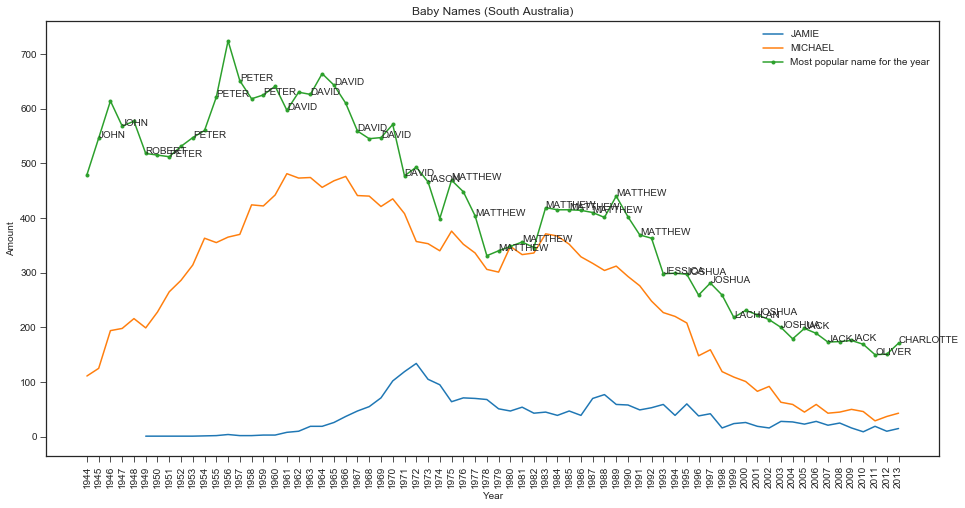

In [40]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)

ax.plot(name1.year, name1.Amount_y)
ax.plot(name2.year, name2.Amount_y)
ax.plot(max_each_year.year, max_each_year.Amount_y, '.-')

ax.set_xticks(all_years)
ax.set_xticklabels(all_years, rotation='vertical')
ax.set_xlabel('Year')
ax.set_ylabel('Amount')
ax.set_title('Baby Names (South Australia)')

for i, row in max_each_year.iterrows():
    if i%2: #plot every other name because graph is too crowded
        ax.text(row.year,row.Amount_y,row['Given Name'])

ax.legend(labels=(name1.iloc[0,0], name2.iloc[0,0],'Most popular name for the year'))

#### 2. Explore least common names<br>
Filter by letter, sex and year, to manage number of results returned.

In [27]:
name_counts = df2.groupby('Given Name').Amount_y.sum()
#also filter by sex because names can exist for either gender
df3 = df2[(df2['Given Name'].str.startswith('A')) & (df2['sex']=='f') & (df2['year']>=2012) & (df2['year']<=2013)]
df3[df3['Given Name'].isin(name_counts.index[name_counts == 1])]['Given Name'].unique()

array(['AABIGAIL', 'AAHLIA-CLARE', 'AALIVIYAH', 'AALIYAH-ROSE', 'AALYAH',
       'AARABI', 'AARIA-JUTTA', 'AARIANA', 'AASINI', 'AAZRA', 'ABAYO',
       'ABBEY-JEAN', 'ABBIYANA', 'ABBIYGALE', 'ABEBA', 'ABHIGNYA',
       'ABISHKKA', 'ABRIE-MAY', 'ABSITIE', 'ADDELINE', 'ADDISON-LEE',
       'ADELIN', 'ADELINDA', 'ADELLE-MARIE', 'ADILYN', 'ADRIARNA',
       'ADVIKA', 'AERIS-JAYDE', 'AGNEL', 'AHORANGI', 'AHWAZ', 'AIISHA',
       'AILLISH', 'AISLYN', 'AITHNE-ANN', 'AIZAH', 'AJIER', 'AJIYAH',
       'AKARI', 'AKITAH', 'AKSHARA', 'AKSHEE', 'AKSHIKA', 'ALAKIER',
       'ALANOOD', 'ALATHEA', 'ALAYLA', 'ALAYSHA', 'ALECTRA', 'ALEESHAA',
       'ALERAH-ROSE', 'ALIANNAH', 'ALILA', 'ALILIA', 'ALLIARNA', 'ALLIERA',
       'ALOFA', 'ALUAK', 'ALWEL', 'ALYRIA', 'AMAHLEE', 'AMAIRA', 'AMARAKA',
       'AMARIAH-GRACE', 'AMATH', 'AMBER-GRACE', 'AMELIA-LEA', 'AMELIA-MAE',
       'AMIRA-LEE', 'AMIRAH-NHU-Y', 'AMIYAH', 'AMYAH', 'ANAAYA', 'ANAE',
       'ANANDI', 'ANASIA', 'ANASTARSIA', 'ANASTASIAH', 'ANASTASIYA

#### 3. Explore names that can be used for both sexes
Explore the name "Jamie" (or another name that can be used for both sexes) and see when the name was used for male and when it was used for female.

In [34]:
df4 = df2[df2['Given Name']=='JAMIE']
df4.groupby('sex')['sex'].count()

sex
f    41
m    61
Name: sex, dtype: int64

In [35]:
df4_f = df4[df4['sex']=='f']
df4_m = df4[df4['sex']=='m']

In [36]:
df4_f.head()

,Given Name,year,sex,Amount_y
13300,JAMIE,1957,f,1
20558,JAMIE,1962,f,1
26557,JAMIE,1966,f,1
29641,JAMIE,1968,f,1
44050,JAMIE,1977,f,4


Use Seaborn to perform a jointplot (scatterplot).

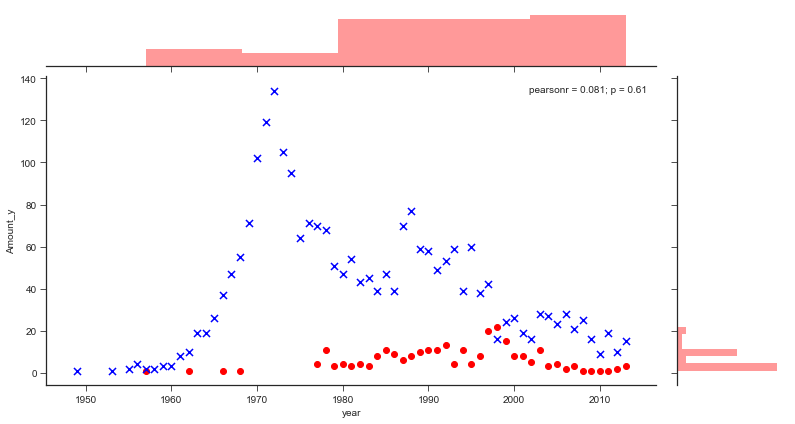

In [37]:
sns.set_style('ticks')

g = sns.jointplot(x=df4_f.year, y=df4_f.Amount_y, data=df4_f, color='r')
g.fig.set_size_inches(12,6)
g.x = df4_m.year
g.y = df4_m.Amount_y

g.plot_joint(plt.scatter, marker='x', c='b', s=50)

Same data but this time using pointplot.

Text(0.5,1,'"Jamie" used for Male and Female')

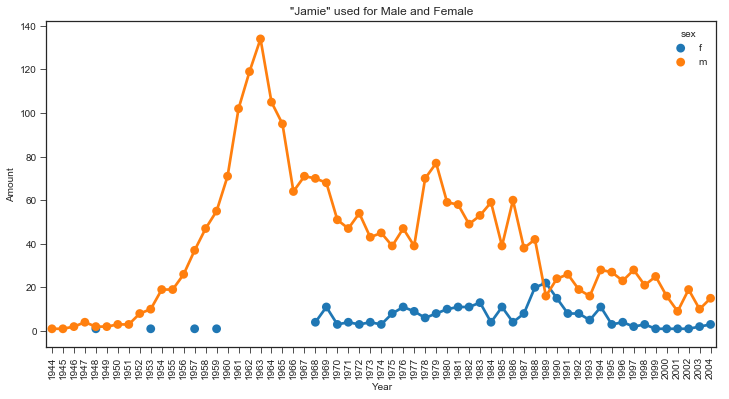

In [38]:
f, ax = plt.subplots(1, 1, figsize=(12,6))
g = sns.pointplot(ax=ax,x=df4.year,y=df4.Amount_y,data=df4,hue='sex')

g.set_xticklabels(all_years, rotation='vertical')
g.set_xlabel('Year')
g.set_ylabel('Amount')
g.set_title('"Jamie" used for Male and Female')